https://en.wikipedia.org/wiki/Observer_pattern#Python
https://en.wikipedia.org/wiki/Reactive_programming
https://stackoverflow.com/questions/6190468/how-to-trigger-function-on-value-change

# Defining a set of inputs for a model

In [1]:
from physipy import m, s, K, kg
import numpy as np

Creation of combinations is no "simple" but very doable using meshgrid : but be carefull, combinations grow **FAST** : 

In [2]:
# uniform sampling
lenghts = np.linspace(0.4, 0.8, num=30)*m
times = np.linspace(1, 10, num=11)*s
temps = np.linspace(300, 310, num=11)*K
# random sampling
mass = np.random.randn(100)*3*kg + 100*kg


LENGTHS, TIMES, TEMPS, MASS= np.meshgrid(lenghts, times, temps, mass)

lenghts = LENGTHS.flatten()
times = TIMES.flatten()
temps = TEMPS.flatten()
mass = MASS.flatten()

In [3]:
print(mass.shape)

(363000,)


Once again, thanks to numpy, we can make a computation for all possibilities at once : 

In [4]:
some_metric = lenghts*times/temps**2*np.exp(mass/(50*kg))

In [5]:
some_metric

<Quantity : [3.60236883e-05 3.27466751e-05 3.09060963e-05 ... 5.46808625e-04
 6.00828220e-04 5.61596440e-04] m*s/K**2, symbol=UndefinedSymbol*UndefinedSymbol/UndefinedSymbol**2*UndefinedSymbol>

# Cache a property with dependency

Based on https://stackoverflow.com/questions/48262273/python-bookkeeping-dependencies-in-cached-attributes-that-might-change

Let's make a simply RC model :

In [6]:
import time
from functools import lru_cache
from operator import attrgetter

def cached_property_depends_on(*args):
    """
    From https://stackoverflow.com/questions/48262273/python-bookkeeping-dependencies-in-cached-attributes-that-might-change
    """
    attrs = attrgetter(*args)
    def decorator(func):
        _cache = lru_cache(maxsize=None)(lambda self, _: func(self))
        def _with_tracked(self):
            return _cache(self, attrs(self))
        return property(_with_tracked, doc=func.__doc__)
    return decorator

import time

class BADTimeConstantRC:
    
    def __init__(self, R, C):
        self.R = R
        self.C = C
        
    @property
    def tau(self):
        print("Slow computation...")
        time.sleep(5)
        return self.R * self.C
    
class GOODTimeConstantRC:
    
    def __init__(self, R, C):
        self.R = R
        self.C = C
    
    @cached_property_depends_on('R', 'C')
    def tau(self):
        print("Slow computation...")
        time.sleep(5)
        return self.R * self.C
    
    
from physipy import units
ohm = units["ohm"]
Farad = units["F"]
bad = BADTimeConstantRC(ohm, Farad)
print("Bad first : ", bad.tau) # This is long the first time...
print("Bad second : ", bad.tau) # ... but also the second time !

good = GOODTimeConstantRC(ohm, Farad)
print("Good fisrt : ", good.tau) # This is long the first time...
print("Good second : ", good.tau) # ... but not the second time since neither R nor C have changed.

Slow computation...
Bad first :  1.0 s
Slow computation...
Bad second :  1.0 s
Slow computation...
Good fisrt :  1.0 s
Good second :  1.0 s


# Dependent model

This is another way to write a model with dependencies. Like the previous one, changing a parameter doesn't immediately triggger a computation of dependendant parameters, only at get-time.

In [4]:
from physipy import units, s
F = units["F"]
ohm = units["ohm"]

from physipy.quantity._acyclic_model import IndependentAttr, DeterminantAttr

class TimeConstant():
    # This class corrects the dependency problems in the DataflowFail class by using the following descriptors:
    # The following defines the directed acyclic computation graph for these attributes.
    R = IndependentAttr(ohm, 'R')
    C = IndependentAttr(F,  'C')
    tau = DeterminantAttr(['R', "C"], '_tau', 'tau')

    def _tau(self):
        print("Throu _tau")
        self.tau = self.R * self.C


tc = TimeConstant()
print(tc.R, tc.C)
print(tc.tau)
tc.R = 2*ohm
print(tc.tau)
print(tc.tau)
tc.R = 2*ohm
print(tc.tau)

1.0 kg*m**2/(A**2*s**3) 1.0 A**2*s**4/(kg*m**2)
Throu _tau
1.0 s
Throu _tau
2.0 s
2.0 s
Throu _tau
2.0 s


In [5]:
print(tc.children)

AttributeError: 'TimeConstant' object has no attribute 'children'

# Better increase the number of MC samples rather than cross-product them

Say you want to simulate random distributions of 2 variables : should you use 100 samples for one, and 100 for the other and then compute all the 100x100=10000 couples possibles OR use 10000 samples for one and 10000 random samples for the other, and just use the 10000 couples.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

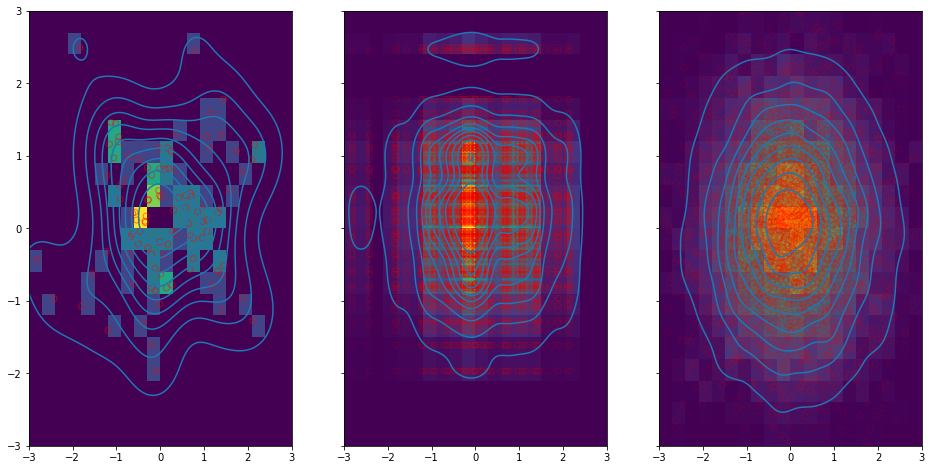

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)

bins=20
xmin=ymin=-3
xmax=ymax=3
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))


axes[0].hist2d(x1, x2, bins=bins, range=[[xmin, xmax], [ymin, ymax]])
axes[0].scatter(x1, x2, alpha=50/len(x1), facecolors='none', edgecolors="r")
sns.kdeplot(x1, x2, ax=axes[0])

X1, X2 = np.meshgrid(x1, x2)

axes[1].hist2d(X1.flatten(), X2.flatten(), bins=bins, range=[[xmin, xmax], [ymin, ymax]])
axes[1].scatter(X1.flatten(), X2.flatten(), alpha=1000/len(X1.flatten()), facecolors='none', edgecolors="r")
sns.kdeplot(X1.flatten(), X2.flatten(), ax=axes[1])

x1_bis = np.random.randn(X1.flatten().size)
x2_bis = np.random.randn(X1.flatten().size)

axes[2].hist2d(x1_bis, x2_bis, bins=bins, range=[[xmin, xmax], [ymin, ymax]])
axes[2].scatter(x1_bis, x2_bis, alpha=1000/len(x1_bis), facecolors='none', edgecolors="r")
sns.kdeplot(x1_bis, x2_bis, ax=axes[2])

# Introspection

Simply use pandas and seaborn, since the inputs and ouputs are basically vectors of data :

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame({
    "length":lenghts.value,
    "times":times.value,
    "temps":temps.value,
    "mass":mass.value,
    "metric":some_metric.value,
})

<AxesSubplot:>

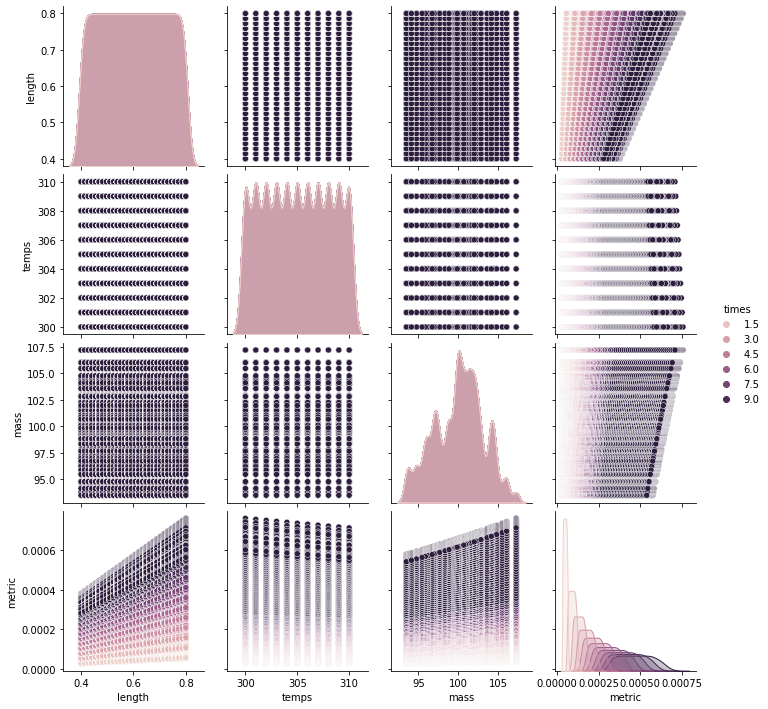

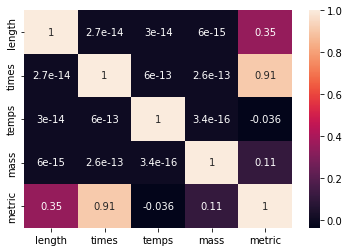

In [12]:
sns.pairplot(df, hue="times")
plt.figure()
sns.heatmap(df.corr(), annot=True)

# Using traitlets

Lets try to make the RC model using traitlets

In [40]:
import traitlets
from physipy import units, s, Quantity
from physipy.qwidgets.qipywidgets import QuantityTextSlider
F = units["F"]
ohm = units["ohm"]



class QuantityDescriptor():

    def __set_name__(self, owner, name):
        # self.R
        self.public_name = name
        # actually refers to self._R_w
        self.private_name = '_' + name

    def __set__(self, obj, value):
        setattr(obj, self.private_name, value)
        
    def __get__(self, obj, objtype=None):
        value = getattr(obj, self.private_name)
        return value

class QuantitySliderDescriptor():
    
    def __set_name__(self, owner, name):
        # self.R
        self.public_name = name
        # actually refers to self._R_w
        self.private_name = '_' + name + "_w"

    
    def __set__(self, obj, value):
        setattr(obj, self.private_name, QuantityTextSlider(value, description=self.public_name))
        
    def __get__(self, obj, objtype=None):
        value = getattr(obj, self.private_name).value
        return value
        
class TraitletsRC():
    """
    To introspect descriptors : 
        # introspect the descriptors/attributes
        print(vars(TraitletsRC(2*ohm, 2*F)))
        # introspect the slider
        print(vars(vars(TraitletsRC(2*ohm, 2*F))["_R_w"]))
    """
    
    R = QuantityDescriptor()
    C = QuantitySliderDescriptor()

    def __init__(self, R, C):
        self.R = R
        self.C = C
        
    @property
    def tau(self):
        return self.R * self.C
    
rc = TraitletsRC(2*ohm, 2*F)

print(rc.R, rc.C)
display(rc.R)
display(rc.C)
display(rc._C_w)

2.0 kg*m**2/(A**2*s**3) 2.0 A**2*s**4/(kg*m**2)


<Quantity : 2.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>

<Quantity : 2.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>

QuantityTextSlider(value=<Quantity : 2.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>, children=(QuantitySli…

In [26]:
type(traitlets_rc._R)
type(traitlets_rc._C_w)

physipy.quantity.quantity.Quantity

In [11]:
print(traitlets_rc.tau)

123.0 kg*m**2/(A**2*s**3)


In [37]:
traitlets_rc.tau

<bound method TraitletsRC.tau of <__main__.TraitletsRC object at 0x131dcc310>>

In [54]:
class Subscriber():
    def react_on_message(self):
        pass

class Publisher():
    def __init__(self):
        self.subscribers = set()
    def register_subscriber(self, who):
        self.subscribers.add(who)
    def dispatch(self, message):
        for sub in self.subcribers:
            sub.react_on_message(message)
    
class Both(Publisher, Subscriber):
    def __init__(self, value):
        super().__init__()
        self.value = value
    def __repr__(self):
        return "<Observable/Observer" + str(self.value)+  ">"

R = Both(1*ohm)
C = Both(1*F)

tau = Both(None)
R.register_subscriber(tau)
C.register_subscriber(tau)